# [作業目標]
- 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [7]:
DAYS_EMPLOYED = app_train['DAYS_EMPLOYED'] / (-365)
bin_cut = [0,10,20,30,40,50]
app_train["equal_width_DAYS_EMPLOYED"] = pd.cut(DAYS_EMPLOYED, [0,10,20,30,40,50])
app_train["equal_width_DAYS_EMPLOYED"] .value_counts().sort_index()

(0, 10]     201181
(10, 20]     38398
(20, 30]      9551
(30, 40]      2771
(40, 50]       234
Name: equal_width_DAYS_EMPLOYED, dtype: int64

/Users/kevinli/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


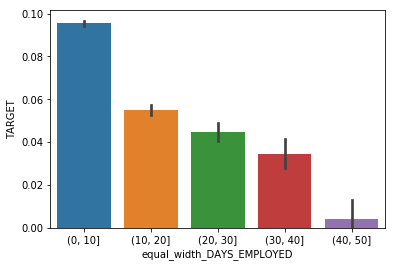

In [8]:
import seaborn as sns
sns.barplot(app_train["equal_width_DAYS_EMPLOYED"],app_train['TARGET'])

In [9]:
#先來看看 'DAYS_BIRTH' 的統計描述吧 (pandas.describe())
print("Correlation between TARGET and DAYS_BIRTH", app_train['DAYS_BIRTH'].corr(app_train['TARGET']))
(app_train['DAYS_BIRTH']/365).describe()

Correlation between TARGET and DAYS_BIRTH 0.07823930830982712


count    307511.000000
mean        -43.936973
std          11.956133
min         -69.120548
25%         -53.923288
50%         -43.150685
75%         -34.008219
max         -20.517808
Name: DAYS_BIRTH, dtype: float64

年齡最小是 20，最大是 69，那我們可以把年齡每 5 歲為一組後再來觀察其與預測目標的關係

In [14]:
#將年齡相關資料, 另外存成一個 DataFrame 來處理
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

#將年齡資料離散化 / 分組

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/Users/kevinli/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kevinli/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,-9461,-25.920548,NaN
1,0,-16765,-45.931507,NaN
2,0,-19046,-52.180822,NaN
3,0,-19005,-52.068493,NaN
4,0,-19932,-54.608219,NaN
5,0,-16941,-46.413699,NaN
6,0,-13778,-37.747945,NaN
7,0,-18850,-51.643836,NaN
8,0,-20099,-55.065753,NaN
9,0,-14469,-39.641096,NaN


In [11]:
#依照組別彙整年齡資料 "每一欄的平均值"
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",NaN,NaN,NaN
"(25.0, 30.0]",NaN,NaN,NaN
"(30.0, 35.0]",NaN,NaN,NaN
"(35.0, 40.0]",NaN,NaN,NaN
"(40.0, 45.0]",NaN,NaN,NaN
"(45.0, 50.0]",NaN,NaN,NaN
"(50.0, 55.0]",NaN,NaN,NaN
"(55.0, 60.0]",NaN,NaN,NaN
"(60.0, 65.0]",NaN,NaN,NaN


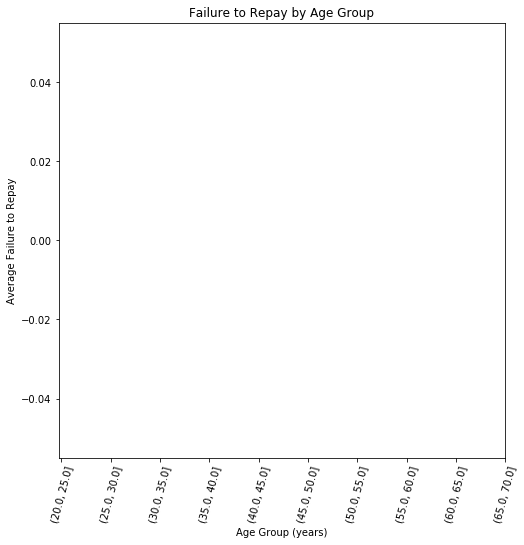

In [12]:
plt.figure(figsize = (8, 8))

# 繪製目標值平均與分組組別的長條圖
plt.bar(range(len(age_groups.index)), age_groups['TARGET'])
# 加上 X, y 座標說明, 以及圖表的標題
plt.xticks(range(len(age_groups.index)), age_groups.index, rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Average Failure to Repay')
plt.title('Failure to Repay by Age Group');